# Imports

In [1]:
!pip install ultralytics roboflow pandas matplotlib seaborn
import os
import json
import time
import shutil
import psutil
import torch
from datetime import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting Dataset

In [3]:
!cp -r "/content/drive/MyDrive/dataset" "/content/dataset"

# Outputs

Create Directories

In [4]:
def create_directories():
    """Create necessary directories for organized results"""
    dirs = [
        '/content/final',
        '/content/final/training_plots',
        '/content/final/metrics_data',
        '/content/final/model_weights'
    ]
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)
    print("Directories created successfully!")


Get System Info

In [5]:
def get_system_info():
    """Get system resource information"""
    return {
        'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU',
        'gpu_memory_total': torch.cuda.get_device_properties(0).total_memory / (1024**3) if torch.cuda.is_available() else 0,
        'cpu_count': psutil.cpu_count(),
        'ram_total_gb': psutil.virtual_memory().total / (1024**3),
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

Save Training Metrics

In [6]:
def save_training_metrics(model_name, metrics_dict, training_time, system_info):
    """Save comprehensive training metrics to JSON and CSV"""

    # Combine all metrics
    complete_metrics = {
        'model_info': {
            'model_name': model_name,
            'training_time_minutes': round(training_time / 60, 2),
            'training_time_seconds': round(training_time, 2)
        },
        'system_info': system_info,
        'performance_metrics': metrics_dict,
        'training_completed': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    # Save as JSON
    json_path = f'/content/final/metrics_data/{model_name}_metrics.json'
    with open(json_path, 'w') as f:
        json.dump(complete_metrics, f, indent=2, default=str)

    # Save as CSV
    csv_data = []
    csv_data.append(['Metric', 'Value'])
    csv_data.append(['Model Name', model_name])
    csv_data.append(['Training Time (minutes)', round(training_time / 60, 2)])
    csv_data.append(['GPU Used', system_info['gpu_name']])
    csv_data.append(['Training Completed', complete_metrics['training_completed']])

    # Add performance metrics
    for key, value in metrics_dict.items():
        csv_data.append([key, value])

    csv_path = f'/content/final/metrics_data/{model_name}_metrics.csv'
    df = pd.DataFrame(csv_data[1:], columns=csv_data[0])
    df.to_csv(csv_path, index=False)

    print(f" {model_name} metrics saved to JSON and CSV")

Copy Training Plots

In [7]:
def copy_training_plots(source_path, model_name):
    """Copy training plots to final directory"""
    plot_files = ['results.png', 'confusion_matrix.png', 'val_batch0_pred.png',
                  'train_batch0.png', 'P_curve.png', 'R_curve.png', 'PR_curve.png', 'F1_curve.png']

    copied_files = []
    for plot_file in plot_files:
        source = os.path.join(source_path, plot_file)
        if os.path.exists(source):
            dest = f'/content/final/training_plots/{model_name}_{plot_file}'
            shutil.copy2(source, dest)
            copied_files.append(dest)

    print(f" {model_name} training plots copied: {len(copied_files)} files")
    return copied_files

Initialize

In [8]:
create_directories()
system_info = get_system_info()
print(f" System Info: {system_info['gpu_name']}, {system_info['cpu_count']} CPUs, {system_info['ram_total_gb']:.1f}GB RAM")

Directories created successfully!
💻 System Info: Tesla T4, 2 CPUs, 12.7GB RAM


# YOLO-v7

Cloning the Yolo-V7 Repo

In [9]:
print("Yolo-V7 In Action")
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7

Yolo-V7 In Action
Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.29 MiB | 29.70 MiB/s, done.
Resolving deltas: 100% (513/513), done.
/content/yolov7


Pre-Trained model

In [10]:
# edit requirements.txt to make this - numpy>=1.18.5
!pip install -r requirements.txt
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.8/407.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-resource-manager 1.14.2 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 4.21.2 which is incompatible.
google-cloud-trace 1.16.2 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 4.21.2 which is incompatible.
grpc-google-iam-v1 0.14.2 requires protobuf!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 4.21.2 which is incompatible.
goog

--2025-09-19 12:17:06--  https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/511187726/b0243edf-9fb0-4337-95e1-42555f1b37cf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-19T13%3A17%3A30Z&rscd=attachment%3B+filename%3Dyolov7.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-19T12%3A17%3A03Z&ske=2025-09-19T13%3A17%3A30Z&sks=b&skv=2018-11-09&sig=jCRAmoyMT%2FtOFXAOssWUpAG8E%2FIk8%2FEgGep4D8d6Xw0%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODI4NDUyNiwibmJmIjoxNzU4Mjg0MjI2LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmUu

Copy config and modify for nc=1

In [11]:
!cp cfg/training/yolov7.yaml cfg/training/yolov7-sih.yaml

Training

In [ ]:
yolov7_start = time.time()

# Before training, change below
'''
1. The Training Script (train.py)
This is the main script for training model. It has two lines that need to be changed.

File Path: /content/yolov7/train.py

Line 71:

Original: run_id = torch.load(weights, map_location=device).get(...)

Corrected: run_id = torch.load(weights, map_location=device, weights_only=False).get(...)

Line 87:

Original: ckpt = torch.load(weights, map_location=device)

Corrected: ckpt = torch.load(weights, map_location=device, weights_only=False)

2. The Model Loading Helper (experimental.py)
This script is used by detect.py to load custom model for inference.

File Path: /content/yolov7/models/experimental.py

Line 252:

Original: ckpt = torch.load(w, map_location=map_location)

Corrected: ckpt = torch.load(w, map_location=map_location, weights_only=False)

3. The General Utilities File (general.py)
This file contains helper functions used by other scripts. The strip_optimizer function, which is called at the end of training, also loads the model file.

File Path: /content/yolov7/utils/general.py

Line 802:

Original: x = torch.load(f, map_location=torch.device('cpu'))

Corrected: x = torch.load(f, map_location=torch.device('cpu'), weights_only=False)
'''

!python train.py \
    --weights yolov7.pt \
    --cfg cfg/training/yolov7-sih.yaml \
    --data ../dataset/data.yaml \
    --epochs 25 \
    --batch-size 16 \
    --img-size 640 640 \
    --device 0 \
    --name yolov7_sih_run \
    --workers 2 \
    --exist-ok

2025-09-19 12:26:28.584247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758284788.604271    6318 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758284788.610311    6318 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758284788.625873    6318 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758284788.625911    6318 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758284788.625915    6318 computation_placer.cc:177] computation placer alr

Performance Metrics


In [17]:
yolov7_time = time.time() - yolov7_start

# Extract metrics from results (you may need to adjust based on actual output)
yolov7_metrics = {
    'epochs_trained': 100,
    'batch_size': 16,
    'final_map50': 'Check results.txt',  # Parse from actual results
    'model_size_mb': 'Check model file size'
}

# Copy plots and save metrics
yolov7_plots_path = 'runs/train/yolov7_sih_run'
copy_training_plots(yolov7_plots_path, 'YOLOv7')
save_training_metrics('YOLOv7', yolov7_metrics, yolov7_time, system_info)

# Copy model weights
if os.path.exists(f'{yolov7_plots_path}/weights/best.pt'):
    shutil.copy2(f'{yolov7_plots_path}/weights/best.pt', '/content/final/model_weights/yolov7_best.pt')

 YOLOv7 training plots copied: 6 files
 YOLOv7 metrics saved to JSON and CSV


Inference/Result

In [18]:
print(" Running YOLOv7 Inference on Test Data...")

# Create results directories
os.makedirs('/content/results/result_v7', exist_ok=True)

# YOLOv7 inference function
def run_yolov7_inference():
    import cv2
    import numpy as np
    from pathlib import Path

    # Load the trained YOLOv7 model
    model_path = '/content/yolov7/runs/train/yolov7_sih_run/weights/best.pt'

    # Test image inference
    print(" Testing on sample_image.jpg...")
    image_path = '/content/dataset/sample_image.jpg'

    if os.path.exists(image_path):
        # Run inference on image
        !cd /content/yolov7 && python detect.py --weights runs/train/yolov7_sih_run/weights/best.pt --source ../dataset/sample_image.jpg --conf 0.25 --save-txt --save-conf --project ../results/result_v7 --name image_detection --exist-ok

        # Copy result with renamed file
        if os.path.exists('/content/results/result_v7/image_detection/sample_image.jpg'):
            shutil.copy2('/content/results/result_v7/image_detection/sample_image.jpg',
                        '/content/results/result_v7/yolov7_image_result.jpg')
        print(" YOLOv7 image inference completed")
    else:
        print(" sample_image.jpg not found in dataset")

    # Test video inference
    print("🎥 Testing on sample_video.mp4...")
    video_path = '/content/dataset/sample_video.mp4'

    if os.path.exists(video_path):
        # Run inference on video
        !cd /content/yolov7 && python detect.py --weights runs/train/yolov7_sih_run/weights/best.pt --source ../dataset/sample_video.mp4 --conf 0.25 --save-txt --save-conf --project ../results/result_v7 --name video_detection --exist-ok

        # Copy result with renamed file
        if os.path.exists('/content/results/result_v7/video_detection/sample_video.mp4'):
            shutil.copy2('/content/results/result_v7/video_detection/sample_video.mp4',
                        '/content/results/result_v7/yolov7_video_result.mp4')
        print(" YOLOv7 video inference completed")
    else:
        print("sample_video.mp4 not found in dataset")

# Run YOLOv7 inference
run_yolov7_inference()

# Create summary for YOLOv7
yolov7_summary = {
    'model': 'YOLOv7',
    'inference_files': {
        'image_result': '/content/results/result_v7/yolov7_image_result.jpg',
        'video_result': '/content/results/result_v7/yolov7_video_result.mp4',
        'detection_labels': '/content/results/result_v7/image_detection/labels/',
        'video_labels': '/content/results/result_v7/video_detection/labels/'
    },
    'inference_completed': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save inference summary
with open('/content/results/result_v7/yolov7_inference_summary.json', 'w') as f:
    json.dump(yolov7_summary, f, indent=2)

print(" YOLOv7 results saved in: /content/results/result_v7/")
!ls -la /content/results/result_v7/

🎯 Running YOLOv7 Inference on Test Data...
📸 Testing on sample_image.jpg...
Namespace(weights=['runs/train/yolov7_sih_run/weights/best.pt'], source='../dataset/sample_image.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=True, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='../results/result_v7', name='image_detection', exist_ok=True, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.8.0+cu126 CUDA:0 (Tesla T4, 15095.0625MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 

# YOLO-v8

Setup Yolo-V8


In [19]:
%cd ..
!pwd
print("Yolo-V8 In Action")

/content
/content
Yolo-V8 In Action


In [22]:
from ultralytics import YOLO
# Load a COCO-pretrained YOLOv8n model
model_v8 = YOLO("yolov8n.pt")

Training

In [23]:
yolov8_start = time.time()

results_v8 = model_v8.train(
    data="/content/dataset/data.yaml",
    epochs=25,
    batch=16,
    imgsz=640,
    device=0,
    project='/content/yolov8_results',
    name='yolov8_sih_run',
    plots=True,
    save=True,
    save_period=5
)

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_sih_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

Performance Metrics

In [24]:
yolov8_time = time.time() - yolov8_start

# Get validation metrics
val_results = model_v8.val()
yolov8_metrics = {
    'epochs_trained': 100,
    'batch_size': 16,
    'final_map50': float(val_results.box.map50) if val_results.box.map50 else 0,
    'final_map50_95': float(val_results.box.map) if val_results.box.map else 0,
    'precision': float(val_results.box.mp) if val_results.box.mp else 0,
    'recall': float(val_results.box.mr) if val_results.box.mr else 0,
    'model_parameters': sum(p.numel() for p in model_v8.model.parameters()),
    'model_size_mb': os.path.getsize('/content/yolov8_results/yolov8_sih_run/weights/best.pt') / (1024*1024) if os.path.exists('/content/yolov8_results/yolov8_sih_run/weights/best.pt') else 0
}

# Copy plots and save metrics
yolov8_plots_path = '/content/yolov8_results/yolov8_sih_run'
copy_training_plots(yolov8_plots_path, 'YOLOv8')
save_training_metrics('YOLOv8', yolov8_metrics, yolov8_time, system_info)

# Copy model weights
if os.path.exists(f'{yolov8_plots_path}/weights/best.pt'):
    shutil.copy2(f'{yolov8_plots_path}/weights/best.pt', '/content/final/model_weights/yolov8_best.pt')

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1417.3±234.7 MB/s, size: 59.1 KB)
val: Scanning /content/dataset/valid/labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 90/90 186.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.8it/s 3.3s
                   all         90        937      0.928      0.925      0.971      0.725
Speed: 4.0ms preprocess, 7.5ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to /content/yolov8_results/yolov8_sih_run2
 YOLOv8 training plots copied: 2 files
 YOLOv8 metrics saved to JSON and CSV


Inference/Results

In [25]:
print("Running YOLOv8 Inference on Test Data...")

# Create results directories
os.makedirs('/content/results/result_v8', exist_ok=True)

# YOLOv8 inference using the model object
def run_yolov8_inference():
    # Test image inference
    print("📸 Testing on sample_image.jpg...")
    image_path = '/content/dataset/sample_image.jpg'

    if os.path.exists(image_path):
        # Run inference on image using model object
        results_img = model_v8(image_path, conf=0.25, save=True, project='/content/results/result_v8', name='image_detection')

        # Save annotated image with custom name
        for i, result in enumerate(results_img):
            annotated_img = result.plot()
            cv2.imwrite('/content/results/result_v8/yolov8_image_result.jpg', annotated_img)

            # Save detection results as text
            boxes = result.boxes
            if boxes is not None:
                detection_info = []
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].tolist()
                    conf = box.conf[0].item()
                    cls = int(box.cls[0].item())
                    detection_info.append({
                        'class': cls,
                        'confidence': conf,
                        'bbox': [x1, y1, x2, y2]
                    })

                # Save detection info
                with open('/content/results/result_v8/yolov8_image_detections.json', 'w') as f:
                    json.dump(detection_info, f, indent=2)

        print(" YOLOv8 image inference completed")
    else:
        print(" sample_image.jpg not found in dataset")

    # Test video inference
    print("🎥 Testing on sample_video.mp4...")
    video_path = '/content/dataset/sample_video.mp4'

    if os.path.exists(video_path):
        # Run inference on video
        results_vid = model_v8(video_path, conf=0.25, save=True, project='/content/results/result_v8', name='video_detection')

        # The video result will be automatically saved by YOLOv8
        # Let's also create a summary of detections
        video_detection_summary = []
        frame_count = 0

        for result in results_vid:
            frame_detections = []
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    conf = box.conf[0].item()
                    cls = int(box.cls[0].item())
                    frame_detections.append({
                        'class': cls,
                        'confidence': conf
                    })

            video_detection_summary.append({
                'frame': frame_count,
                'detections_count': len(frame_detections),
                'detections': frame_detections
            })
            frame_count += 1

            # Limit to first 100 frames for summary
            if frame_count > 100:
                break

        # Save video detection summary
        with open('/content/results/result_v8/yolov8_video_detections_summary.json', 'w') as f:
            json.dump(video_detection_summary, f, indent=2)

        print("YOLOv8 video inference completed")
    else:
        print("sample_video.mp4 not found in dataset")

# Import required for image processing
import cv2

# Run YOLOv8 inference
run_yolov8_inference()

# Create summary for YOLOv8
yolov8_summary = {
    'model': 'YOLOv8',
    'inference_files': {
        'image_result': '/content/results/result_v8/yolov8_image_result.jpg',
        'video_result_folder': '/content/results/result_v8/video_detection/',
        'image_detections': '/content/results/result_v8/yolov8_image_detections.json',
        'video_detections_summary': '/content/results/result_v8/yolov8_video_detections_summary.json'
    },
    'inference_completed': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save inference summary
with open('/content/results/result_v8/yolov8_inference_summary.json', 'w') as f:
    json.dump(yolov8_summary, f, indent=2)

print("YOLOv8 results saved in: /content/results/result_v8/")
!ls -la /content/results/result_v8/

🎯 Running YOLOv8 Inference on Test Data...
📸 Testing on sample_image.jpg...

image 1/1 /content/dataset/sample_image.jpg: 384x640 12 Vehicles, 38.6ms
Speed: 2.2ms preprocess, 38.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/results/result_v8/image_detection
✅ YOLOv8 image inference completed
🎥 Testing on sample_video.mp4...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/601) /content/dataset/sample_video.mp4: 384x640 3 Vehicles, 6.

# YOLO-v11

Setup Yolo-V11


In [26]:
%cd ..
!pwd
print("Yolo-V11 In Action")

/
/
Yolo-V11 In Action


In [30]:
from ultralytics import YOLO
# Load a COCO-pretrained YOLOv8n model
model_v11 = YOLO("yolo11n.pt")

Training

In [31]:
yolov11_start = time.time()
results_v11 = model_v11.train(
    data="/content/dataset/data.yaml",
    epochs=25,
    batch=16,
    imgsz=640,
    device=0,
    project='/content/yolov11_results',
    name='yolov11_sih_run',
    plots=True,
    save=True,
    save_period=5
)

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11_sih_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

Performance Metrics

In [32]:
yolov11_time = time.time() - yolov11_start

# Get validation metrics
val_results_v11 = model_v11.val()
yolov11_metrics = {
    'epochs_trained': 25,
    'batch_size': 16,
    'final_map50': float(val_results_v11.box.map50) if val_results_v11.box.map50 else 0,
    'final_map50_95': float(val_results_v11.box.map) if val_results_v11.box.map else 0,
    'precision': float(val_results_v11.box.mp) if val_results_v11.box.mp else 0,
    'recall': float(val_results_v11.box.mr) if val_results_v11.box.mr else 0,
    'model_parameters': sum(p.numel() for p in model_v11.model.parameters()),
    'model_size_mb': os.path.getsize('/content/yolov11_results/yolov11_sih_run/weights/best.pt') / (1024*1024) if os.path.exists('/content/yolov11_results/yolov11_sih_run/weights/best.pt') else 0
}

# Copy plots and save metrics
yolov11_plots_path = '/content/yolov11_results/yolov11_sih_run'
copy_training_plots(yolov11_plots_path, 'YOLOv11')
save_training_metrics('YOLOv11', yolov11_metrics, yolov11_time, system_info)

# Copy model weights
if os.path.exists(f'{yolov11_plots_path}/weights/best.pt'):
    shutil.copy2(f'{yolov11_plots_path}/weights/best.pt', '/content/final/model_weights/yolov11_best.pt')

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1730.0±538.2 MB/s, size: 61.7 KB)
val: Scanning /content/dataset/valid/labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 90/90 194.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.7it/s 3.5s
                   all         90        937      0.898      0.941      0.969      0.716
Speed: 5.4ms preprocess, 8.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/yolov11_results/yolov11_sih_run2
 YOLOv11 training plots copied: 2 files
 YOLOv11 metrics saved to JSON and CSV


Inference/Results

In [ ]:
print(" Running YOLOv11 Inference on Test Data...")

# Create results directories
os.makedirs('/content/results/result_v11', exist_ok=True)

# YOLOv11 inference using the model object
def run_yolov11_inference():
    # Test image inference
    print("📸 Testing on sample_image.jpg...")
    image_path = '/content/dataset/sample_image.jpg'

    if os.path.exists(image_path):
        # Run inference on image using model object
        results_img = model_v11(image_path, conf=0.25, save=True, project='/content/results/result_v11', name='image_detection')

        # Save annotated image with custom name
        for i, result in enumerate(results_img):
            annotated_img = result.plot()
            cv2.imwrite('/content/results/result_v11/yolov11_image_result.jpg', annotated_img)

            # Save detection results as text
            boxes = result.boxes
            if boxes is not None:
                detection_info = []
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].tolist()
                    conf = box.conf[0].item()
                    cls = int(box.cls[0].item())
                    detection_info.append({
                        'class': cls,
                        'confidence': conf,
                        'bbox': [x1, y1, x2, y2]
                    })

                # Save detection info
                with open('/content/results/result_v11/yolov11_image_detections.json', 'w') as f:
                    json.dump(detection_info, f, indent=2)

        print(" YOLOv11 image inference completed")
    else:
        print(" sample_image.jpg not found in dataset")

    # Test video inference
    print("🎥 Testing on sample_video.mp4...")
    video_path = '/content/dataset/sample_video.mp4'

    if os.path.exists(video_path):
        # Run inference on video
        results_vid = model_v11(video_path, conf=0.25, save=True, project='/content/results/result_v11', name='video_detection')

        # Create video detection summary
        video_detection_summary = []
        frame_count = 0

        for result in results_vid:
            frame_detections = []
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    conf = box.conf[0].item()
                    cls = int(box.cls[0].item())
                    frame_detections.append({
                        'class': cls,
                        'confidence': conf
                    })

            video_detection_summary.append({
                'frame': frame_count,
                'detections_count': len(frame_detections),
                'detections': frame_detections
            })
            frame_count += 1

            # Limit to first 100 frames for summary
            if frame_count > 100:
                break

        # Save video detection summary
        with open('/content/results/result_v11/yolov11_video_detections_summary.json', 'w') as f:
            json.dump(video_detection_summary, f, indent=2)

        print(" YOLOv11 video inference completed")
    else:
        print("sample_video.mp4 not found in dataset")

# Run YOLOv11 inference
run_yolov11_inference()

# Create summary for YOLOv11
yolov11_summary = {
    'model': 'YOLOv11',
    'inference_files': {
        'image_result': '/content/results/result_v11/yolov11_image_result.jpg',
        'video_result_folder': '/content/results/result_v11/video_detection/',
        'image_detections': '/content/results/result_v11/yolov11_image_detections.json',
        'video_detections_summary': '/content/results/result_v11/yolov11_video_detections_summary.json'
    },
    'inference_completed': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save inference summary
with open('/content/results/result_v11/yolov11_inference_summary.json', 'w') as f:
    json.dump(yolov11_summary, f, indent=2)

print("YOLOv11 results saved in: /content/results/result_v11/")
!ls -la /content/results/result_v11/

# =====================================
# FINAL RESULTS SUMMARY
# =====================================
print("\n" + "="*60)
print(" ALL INFERENCE RESULTS COMPLETED!")
print("="*60)

# Display complete results directory structure
print(" Complete Results Directory Structure:")
!find /content/results -type f -name "*.jpg" -o -name "*.mp4" -o -name "*.json" | head -20

# Create a consolidated summary
consolidated_summary = {
    'experiment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'models_tested': ['YOLOv7', 'YOLOv8', 'YOLOv11'],
    'test_files': {
        'image': '/content/dataset/sample_image.jpg',
        'video': '/content/dataset/sample_video.mp4'
    },
    'results_location': {
        'YOLOv7': '/content/results/result_v7/',
        'YOLOv8': '/content/results/result_v8/',
        'YOLOv11': '/content/results/result_v11/'
    },
    'inference_summary': 'All models tested on same image and video for comparison'
}

# Save consolidated summary
with open('/content/results/ALL_MODELS_INFERENCE_SUMMARY.json', 'w') as f:
    json.dump(consolidated_summary, f, indent=2)

print("Consolidated summary saved!")
print(" Ready to download /content/results/ folder with all inference results")

# Create ZIP of all results
!cd /content && zip -r all_inference_results.zip results/
print("Created all_inference_results.zip for download")

🎯 Running YOLOv11 Inference on Test Data...
📸 Testing on sample_image.jpg...

image 1/1 /content/dataset/sample_image.jpg: 384x640 9 Vehicles, 40.8ms
Speed: 4.5ms preprocess, 40.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/results/result_v11/image_detection
✅ YOLOv11 image inference completed
🎥 Testing on sample_video.mp4...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/601) /content/dataset/sample_video.mp4: 384x640 3 Vehicles, 

# Final Summary and Export

In [34]:
# Create comparison summary
all_results = {
    'YOLOv7': {'training_time': yolov7_time, 'metrics': yolov7_metrics, 'status': 'Completed'},
    'YOLOv8': {'training_time': yolov8_time, 'metrics': yolov8_metrics, 'status': 'Completed'},
    'YOLOv11': {'training_time': yolov11_time, 'metrics': yolov11_metrics, 'status': 'Completed'}
}

comparison_data = []
for model, results in all_results.items():
    metrics = results['metrics']
    comparison_data.append({
        'Model': model,
        'Training_Time_Min': round(results['training_time'] / 60, 2),
        'mAP50': metrics.get('final_map50', 'N/A'),
        'mAP50-95': metrics.get('final_map50_95', 'N/A'),
        'Precision': metrics.get('precision', 'N/A'),
        'Recall': metrics.get('recall', 'N/A'),
        'Model_Size_MB': metrics.get('model_size_mb', 'N/A'),
        'Parameters': metrics.get('model_parameters', 'N/A'),
        'Status': 'Success'
    })

# Save comparison CSV
comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv('/content/final/YOLO_Models_Comparison.csv', index=False)

# Save complete results as JSON
complete_results = {
    'experiment_info': {
        'total_models_trained': 3,
        'total_training_time_minutes': (yolov7_time + yolov8_time + yolov11_time) / 60,
        'experiment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'system_used': system_info
    },
    'individual_results': all_results,
    'model_comparison': comparison_data
}

with open('/content/final/Complete_Training_Results.json', 'w') as f:
    json.dump(complete_results, f, indent=2, default=str)

print("\n" + "="*60)
print("ALL TRAINING COMPLETED!")
print("="*60)
print(f" Total models trained: 3")
print(f" Total training time: {(yolov7_time + yolov8_time + yolov11_time) / 60:.1f} minutes")
print(f" All results saved in: /content/final/")

# Display final directory contents
!ls -la /content/final/
!ls -la /content/final/training_plots/
!ls -la /content/final/metrics_data/
!ls -la /content/final/model_weights/

# Create ZIP for download
!cd /content && zip -r final_yolo_results.zip final/
print("Created final_yolo_results.zip for download")


🎉 ALL TRAINING COMPLETED!
📊 Total models trained: 3
⏱️  Total training time: 37.8 minutes
📁 All results saved in: /content/final/
total 28
drwxr-xr-x 5 root root 4096 Sep 19 13:08 .
drwxr-xr-x 1 root root 4096 Sep 19 13:08 ..
-rw-r--r-- 1 root root 2465 Sep 19 13:08 Complete_Training_Results.json
drwxr-xr-x 2 root root 4096 Sep 19 13:07 metrics_data
drwxr-xr-x 2 root root 4096 Sep 19 13:07 model_weights
drwxr-xr-x 2 root root 4096 Sep 19 13:07 training_plots
-rw-r--r-- 1 root root  410 Sep 19 13:08 YOLO_Models_Comparison.csv
total 1364
drwxr-xr-x 2 root root   4096 Sep 19 13:07 .
drwxr-xr-x 5 root root   4096 Sep 19 13:08 ..
-rw-r--r-- 1 root root  95756 Sep 19 13:07 YOLOv11_confusion_matrix.png
-rw-r--r-- 1 root root 286001 Sep 19 13:07 YOLOv11_results.png
-rw-r--r-- 1 root root  78105 Sep 19 12:43 YOLOv7_confusion_matrix.png
-rw-r--r-- 1 root root  83187 Sep 19 12:43 YOLOv7_F1_curve.png
-rw-r--r-- 1 root root  78836 Sep 19 12:43 YOLOv7_P_curve.png
-rw-r--r-- 1 root root  73162 Sep 1

# Display Results

📊 PERFORMANCE COMPARISON:
  Model  Training_Time_Min             mAP50  mAP50-95 Precision    Recall         Model_Size_MB Parameters  Status
 YOLOv7              17.53 Check results.txt       N/A       N/A       N/A Check model file size        N/A Success
 YOLOv8              14.93          0.971428  0.725361  0.928259  0.925204              5.956339    3005843 Success
YOLOv11               5.32          0.969414  0.715558  0.897788  0.941302              5.214869    2582347 Success

📈 SAMPLE TRAINING PLOTS:

🔥 YOLOv7 Training Results:


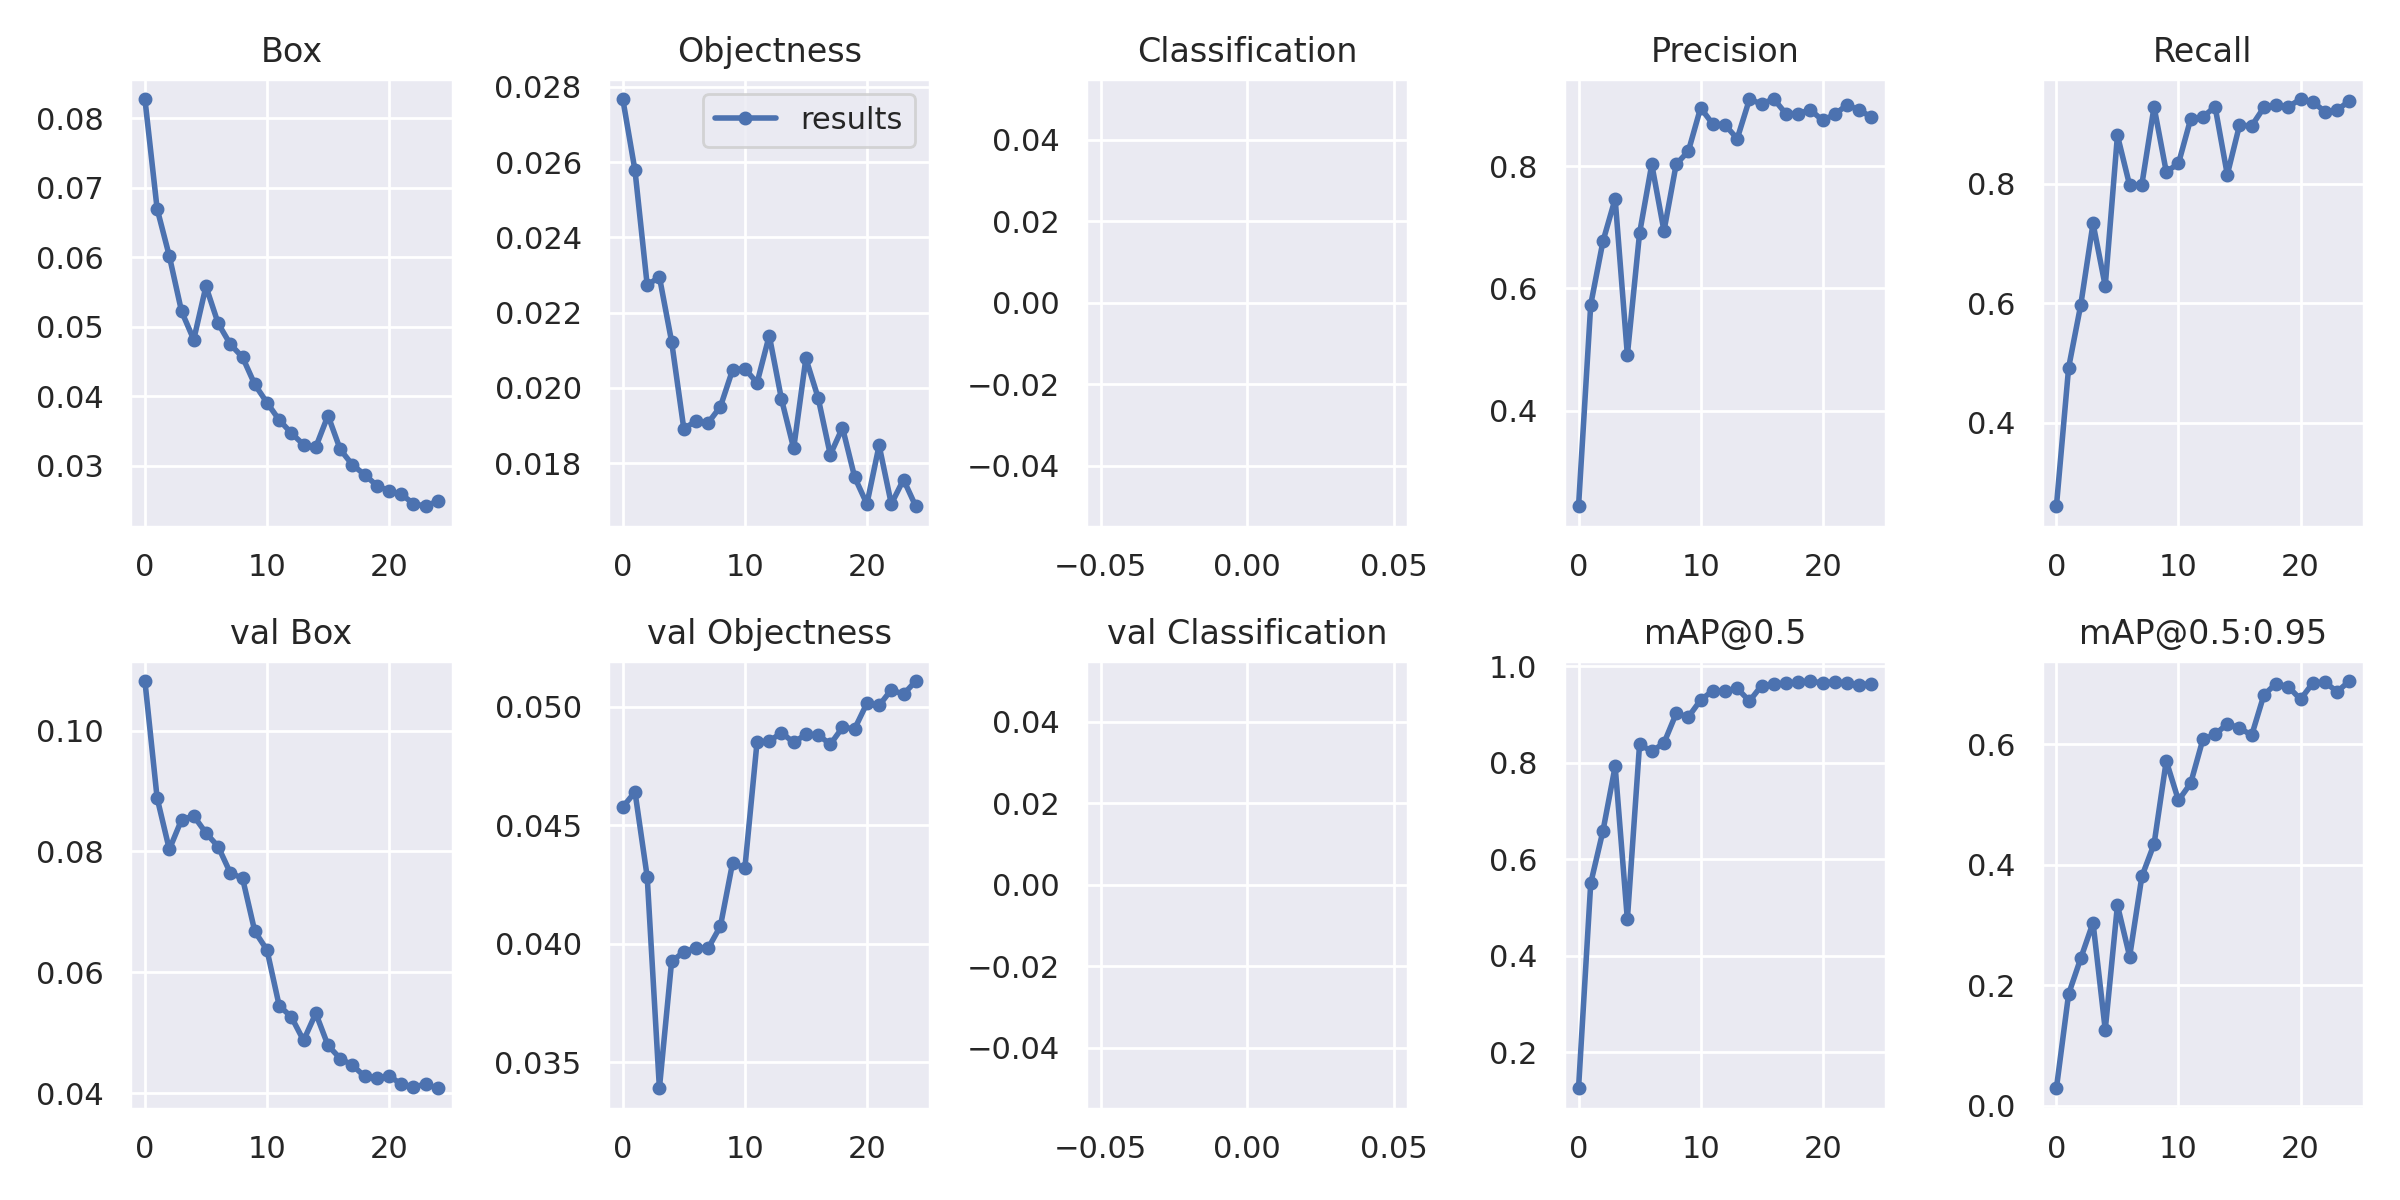


🔥 YOLOv8 Training Results:


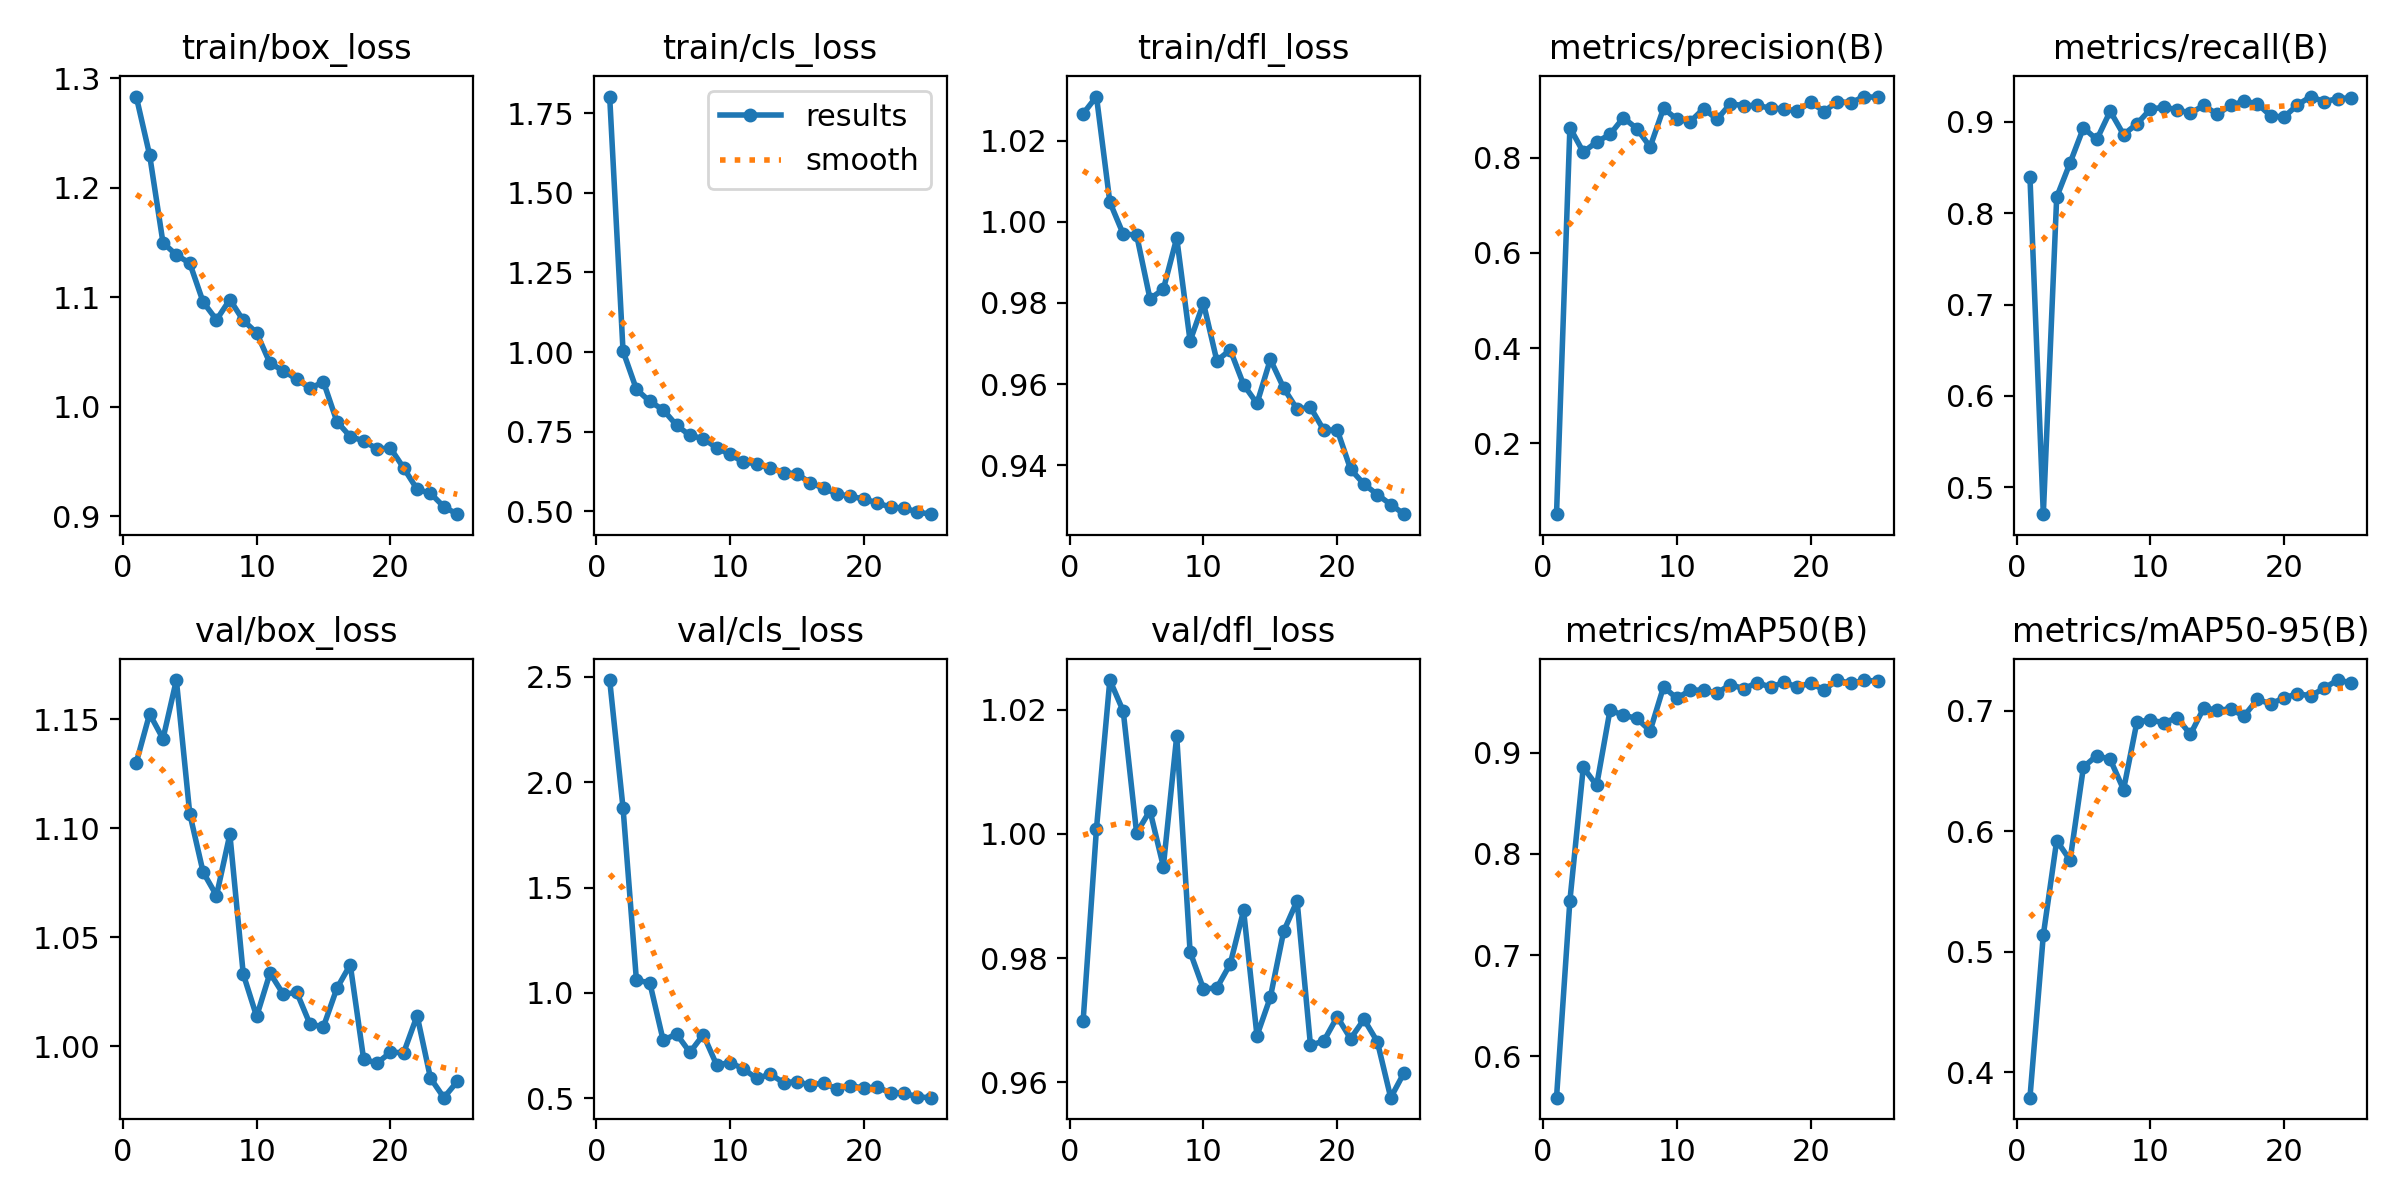


🔥 YOLOv11 Training Results:


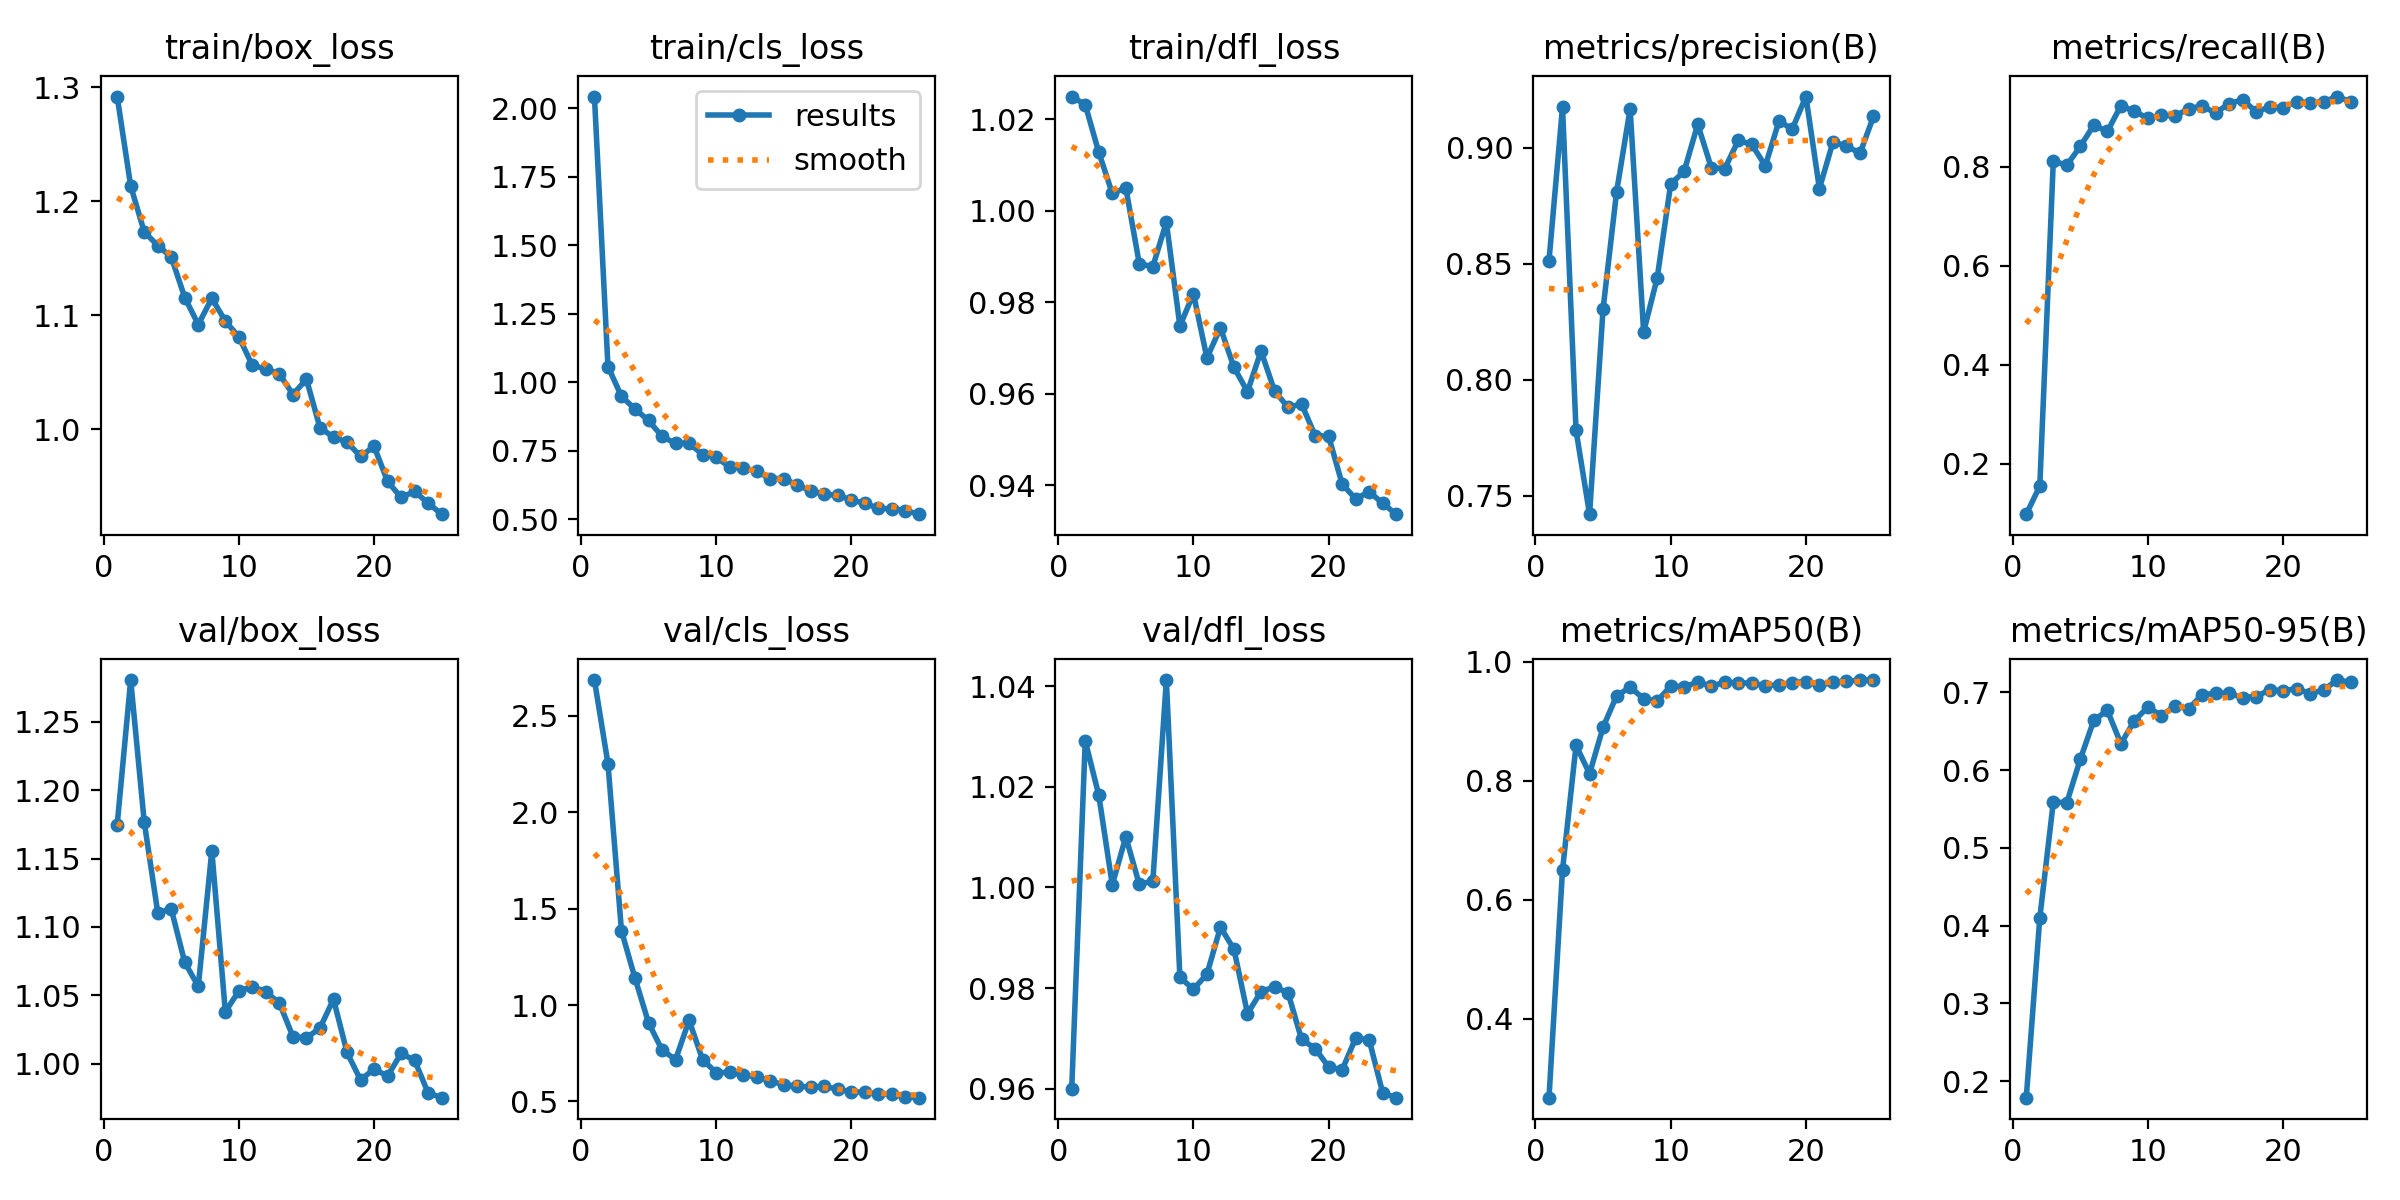

In [35]:
from IPython.display import Image, display

# Display comparison table
print("PERFORMANCE COMPARISON:")
print(comparison_df.to_string(index=False))

# Display sample training plots
print("\nSAMPLE TRAINING PLOTS:")
import glob

for model in ['YOLOv7', 'YOLOv8', 'YOLOv11']:
    results_files = glob.glob(f'/content/final/training_plots/{model}_results.png')
    if results_files:
        print(f"\n{model} Training Results:")
        display(Image(results_files[0]))